<a href="https://colab.research.google.com/github/hrithikwel8/Rossmann_Sales_Prediction/blob/main/Pradip_Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load the datasets
path = '/content/drive/MyDrive/Capstone Project/Retail Sales Prediction/data/'
store_data_df = pd.read_csv(path + 'Rossmann Stores Data.csv')
store_df = pd.read_csv(path + 'store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#1. EDA

In [ ]:
store_data_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [ ]:
store_data_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
# changing date from string to integer value so wee can sort the data
def date_to_int(date):
  new_date = date[:4] + date[5:7] + date[8:]
  return int(new_date)
store_data_df['new_date'] = store_data_df['Date'].apply(lambda x: date_to_int(x))

In [ ]:
store_data_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,new_date
0,1,5,2015-07-31,5263,555,1,1,0,1,20150731
1,2,5,2015-07-31,6064,625,1,1,0,1,20150731
2,3,5,2015-07-31,8314,821,1,1,0,1,20150731
3,4,5,2015-07-31,13995,1498,1,1,0,1,20150731
4,5,5,2015-07-31,4822,559,1,1,0,1,20150731


Text(0.5, 0, '')

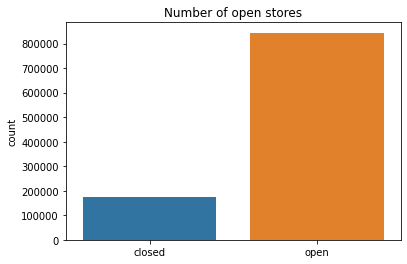

In [ ]:
# number of stores open on a given day
count = sns.countplot(x=store_data_df['Open'])
count.set_title('Number of open stores')
count.set_xticklabels(['closed', 'open'])
count.set_xlabel('')

Text(0.5, 0, '')

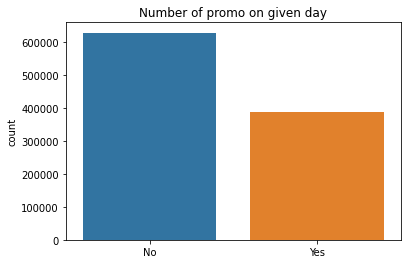

In [ ]:
# number of promo 
count = sns.countplot(x=store_data_df['Promo'])
count.set_title('Number of promo on given day')
count.set_xticklabels(['No', 'Yes'])
count.set_xlabel('')

Text(0.5, 0, '')

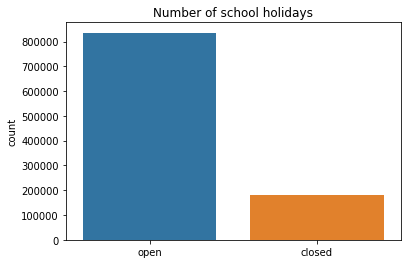

In [ ]:
# number of school holiday
count = sns.countplot(x=store_data_df['SchoolHoliday'])
count.set_title('Number of school holidays')
count.set_xticklabels(['open', 'closed'])
count.set_xlabel('')

In [ ]:
store_data_df['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [ ]:
# convert StateHoliday to features
# 1 indicates holiday and 0 indicates no holiday
store_data_df['public_holiday'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='a' else 0)
store_data_df['easter_holiday'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='b' else 0)
store_data_df['christmas'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='c' else 0)

In [ ]:
store_data_df['DayOfWeek'].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

In [ ]:
# convert day of week to binary features
store_data_df['DayOfWeek1'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==1 else 0)
store_data_df['DayOfWeek2'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==2 else 0)
store_data_df['DayOfWeek3'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==3 else 0)
store_data_df['DayOfWeek4'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==4 else 0)
store_data_df['DayOfWeek5'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==5 else 0)
store_data_df['DayOfWeek6'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==6 else 0)
store_data_df['DayOfWeek7'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==7 else 0)

In [ ]:
# drop columnns
store_data_df.drop(columns=['StateHoliday', 'Date', 'DayOfWeek'], inplace=True)

In [ ]:
store_data_df['public_holiday'].value_counts()

0    996949
1     20260
Name: public_holiday, dtype: int64

In [ ]:
store_data_df['easter_holiday'].value_counts()

0    1010519
1       6690
Name: easter_holiday, dtype: int64

In [ ]:
store_data_df['christmas'].value_counts()

0    1013109
1       4100
Name: christmas, dtype: int64

Text(0.5, 1.0, 'Number of Holidays celebrated by stores')

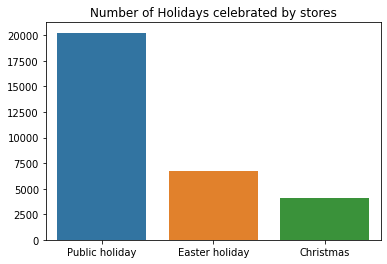

In [ ]:
# plot number of holidays present in dataset
sns.barplot(x=['Public holiday','Easter holiday','Christmas'],
            y=[store_data_df['public_holiday'].value_counts()[1],store_data_df['easter_holiday'].value_counts()[1],store_data_df['christmas'].value_counts()[1]])
plt.title('Number of Holidays celebrated by stores')

In [ ]:
store_data_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,new_date,public_holiday,easter_holiday,christmas
0,1,5,5263,555,1,1,1,20150731,0,0,0
1,2,5,6064,625,1,1,1,20150731,0,0,0
2,3,5,8314,821,1,1,1,20150731,0,0,0
3,4,5,13995,1498,1,1,1,20150731,0,0,0
4,5,5,4822,559,1,1,1,20150731,0,0,0


In [ ]:
# checking senity of data
store_open_df = store_data_df.groupby(['Open']).sum()
store_open_df

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,new_date,public_holiday,easter_holiday,christmas
Open,,,,,,,,,,
0,96511898,1094583,0,0,11184,18264,3480351279995,19566,6545,4029
1,471527846,2972565,5873180623,644041755,376896,163457,17005142750924,694,145,71


In [ ]:
# calculate number of sstores open on holidays
store_holiday_df = store_open_df.drop(columns=['Store','DayOfWeek','Sales','Customers','Promo','new_date']).reset_index()
store_holiday_df['Open'] = store_holiday_df['Open'].apply(lambda x: 'Open' if x==1 else 'Closed')
store_holiday_df

,Open,SchoolHoliday,public_holiday,easter_holiday,christmas
0,Closed,18264,19566,6545,4029
1,Open,163457,694,145,71


In [ ]:
store_holiday_df= pd.melt(store_holiday_df, id_vars =['Open'])
store_holiday_df

,Open,variable,value
0,Closed,SchoolHoliday,18264
1,Open,SchoolHoliday,163457
2,Closed,public_holiday,19566
3,Open,public_holiday,694
4,Closed,easter_holiday,6545
5,Open,easter_holiday,145
6,Closed,christmas,4029
7,Open,christmas,71


Text(0.5, 1.0, 'Number of stores open on holidays')

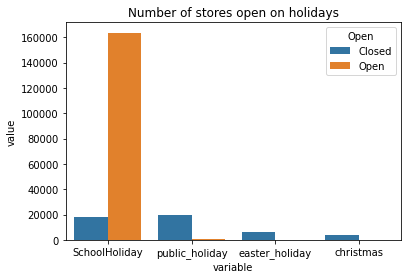

In [ ]:
sns.barplot(x='variable',y='value',data=store_holiday_df,hue='Open')
plt.title('Number of stores open on holidays')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f16f1506d50>,
      dtype=object)

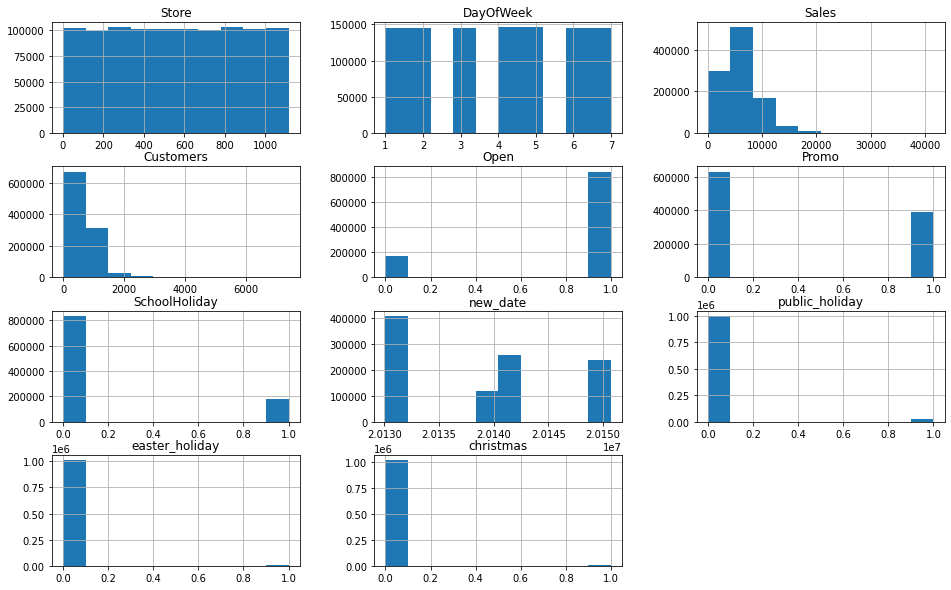

In [ ]:
# plot the distribution of values
store_data_df.hist(figsize=(16,10))

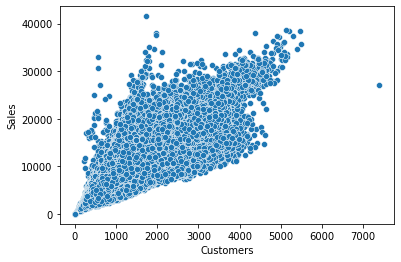

In [ ]:
# plot relation between sales and customer
sns.scatterplot(data=store_data_df,x='Customers',y='Sales')

Text(0.5, 1.0, 'Correlation matrix')

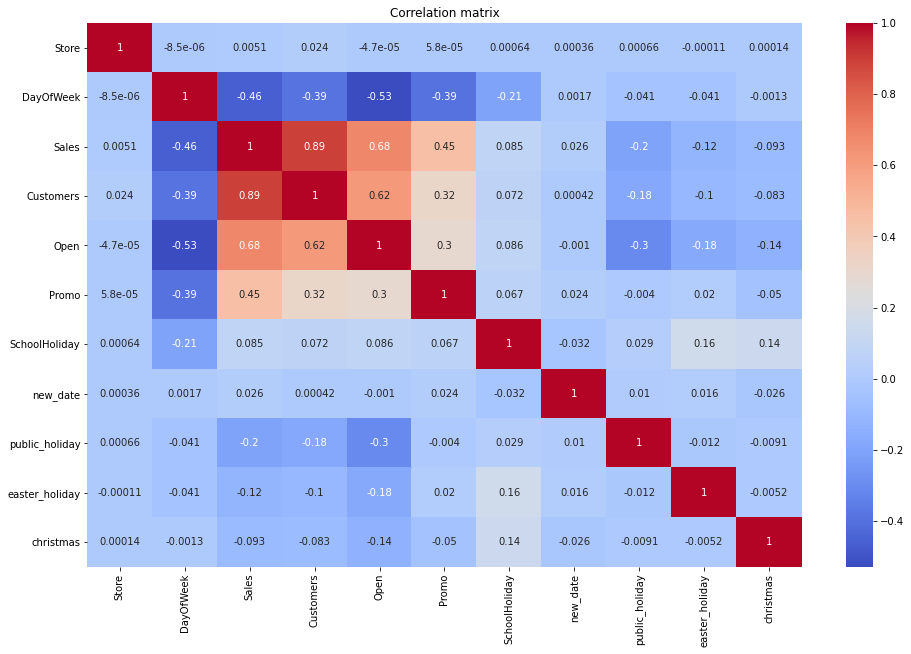

In [ ]:
# plot correlation matrix
plt.figure(figsize=(16,10))
sns.heatmap(store_data_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation matrix')

In [ ]:
# updating promo2 for given date
def continuous_promotion(data):
  promo_month = False
  # promo2 is valid for stores that participate in continuous and consecutive promotion
  if data['Promo2'] == 1:
    # promotion should be running on current month
    current_month = int((data['new_date']//100)%100)
    if ((current_month % 3 == 1) and (data['PromoInterval1'] == 1)):
      promo_month = True
    if ((current_month % 3 == 2) and (data['PromoInterval2'] == 1)):
      promo_month = True
    if ((current_month % 3 == 0) and (data['PromoInterval3'] == 1)):
      promo_month = True
    # if current moth is promo month then promotion should start before current date
    if promo_month:
      if ((data['new_date']/10000) > data['Promo2SinceYear']):
        # promo2 start before current year
        return 1
      if ((data['new_date']/10000) == data['Promo2SinceYear']):
        # promo2 start on this year
        if (current_month > ((data['Promo2SinceWeek']//4)+1)):
          # promo2 start before current month
          return 1
  return 0

In [ ]:
# combine features for promo2
sales_df['Promo_cont'] = sales_df.apply(continuous_promotion, axis=1)

In [ ]:
# remove columns
sales_df.drop(columns=['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3'], inplace=True)